<a href="https://colab.research.google.com/github/AfrozSaqlain/Physics-Informed-Neural-Network/blob/main/TISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import math
from scipy.special import hermite
from scipy.linalg import eigh_tridiagonal

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We know that the Schrodinger equation looks like:

$$
  - \frac{\hbar^2}{2m} \frac{d^2 \psi(x)}{dx^2} + V(x) \psi(x) = E \psi(x)
$$

Taking the potential to be a simple harmonic oscillator, we have

$$V(x) = \frac{1}{2} m \omega^2 x^2$$

Thus, our Schrodinger equation will then look like:

$$
  \left[- \frac{\hbar^2}{2m} \frac{d^2}{dx^2} + \frac{1}{2} m \omega^2 x^2 \right] \psi(x) = E \psi(x)
$$

The energy eigenvalue is then given by:

$$
  E_n = \hbar \omega \left( n + \frac{1}{2} \right)
$$

In [21]:
# class TISE(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(TISE, self).__init__()
#         self.hidden_size = hidden_size
#         self.input_size = input_size
#         self.output_size = output_size

#         self.layer = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.Tanh(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.Tanh(),
#             nn.Linear(hidden_size, output_size)
#         )

#     def forward(self, x):
#         return self.layer(x)

# Custom Sine activation function
class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class FCN(nn.Module):
    def __init__(self, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        self.activation = SineActivation()  # Use the sine activation function
        self.initial_layer = nn.Linear(1, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.activation(self.initial_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

# Example usage
N_OUTPUT = 1  # Output size
N_HIDDEN = 50  # Number of neurons in the hidden layers
N_LAYERS = 3  # Number of hidden layers

model_0 = FCN(N_OUTPUT, N_HIDDEN, N_LAYERS)

In [22]:
def potential(x):
  return (1/2) * (x**2)

def energy(n):
  return n + 1/2

def residual(model, potential, x, n):
    x = x.requires_grad_(True)
    psi = model(x)

    dy_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True, retain_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x, grad_outputs=torch.ones_like(dy_dx), create_graph=True, retain_graph=True)[0]

    res = - (1/2) * d2y_dx2 + potential(x) * psi - energy(n) * psi
    return 5e-3 * torch.mean(res**2)


def bc_loss(model, boundary):
    x_bc = torch.tensor([[boundary[0]], [boundary[1]]], dtype=torch.float32).to(DEVICE)
    psi_bc = model(x_bc)
    return torch.mean(psi_bc ** 2)


def total_loss(model, x, n, boundary):
  return 1e0 * residual(model, potential, x, n) + bc_loss(model, boundary)


def train_pinn(model, n, boundary, optimizer, scheduler, x_train, epochs, patience=500):
    best_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss(model, x_train, n, boundary)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Early stopping mechanism
        if loss.item() < best_loss:
            best_loss = loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Training stopped early due to plateau in learning.")
            break

In [23]:
epochs = 5000

# model_0 = TISE(input_size = 1, hidden_size = 30, output_size = 1).to(DEVICE)
optimizer = optim.AdamW(model_0.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

In [24]:
boundary = (-5.0, 5.0)
n = 2

N_collocation = 5000
x_train = torch.tensor(np.linspace(boundary[0], boundary[1], N_collocation), dtype=torch.float32).unsqueeze(1)
x_train = x_train.to(DEVICE)

In [25]:
train_pinn(model_0, n, boundary, optimizer, scheduler, x_train, epochs, patience=200)

Epoch 0, Loss: 0.02874874323606491, Learning Rate: 9.999999022909196e-05
Epoch 500, Loss: 9.808577488001902e-06, Learning Rate: 9.756767728991498e-05
Epoch 1000, Loss: 2.025267917815654e-07, Learning Rate: 9.052805215781012e-05
Epoch 1500, Loss: 1.5114544282823772e-07, Learning Rate: 7.957020238866026e-05
Epoch 2000, Loss: 1.3332200410332007e-07, Learning Rate: 6.576675866569852e-05
Epoch 2500, Loss: 1.2354146861071058e-07, Learning Rate: 5.0468898234775864e-05
Epoch 3000, Loss: 1.175220702975821e-07, Learning Rate: 3.5174082261332036e-05
Epoch 3500, Loss: 1.1352306472645068e-07, Learning Rate: 2.1379473898096796e-05
Epoch 4000, Loss: 1.1101538888169671e-07, Learning Rate: 1.0435385524351717e-05
Epoch 4500, Loss: 1.0977965558822689e-07, Learning Rate: 3.4131007620663697e-06


In [26]:
y_val = model_0(x_train)

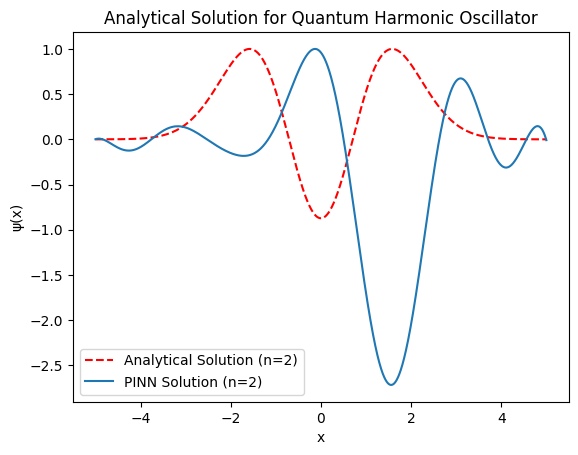

In [27]:
def analytical_wavefunction(n, x):
    H_n = hermite(n)
    norm_factor = 1 / np.sqrt(2**n * math.factorial(n) * np.sqrt(np.pi))
    return norm_factor * np.exp(-x**2 / 2) * H_n(x)

def harmonic_potential(x):
    return 0.5 * x**2

x_vals = np.linspace(boundary[0], boundary[1], N_collocation)

psi_analytical = analytical_wavefunction(n, x_vals)

psi_analytical /= np.sqrt(np.trapz(psi_analytical**2, x_vals))


plt.plot(x_vals, psi_analytical / np.max(psi_analytical), label=f"Analytical Solution (n={n})", linestyle="--", color="red")
plt.plot(x_train.detach().numpy(), y_val.detach().numpy() / np.max(y_val.detach().numpy()), label=f"PINN Solution (n={n})")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.title("Analytical Solution for Quantum Harmonic Oscillator")
plt.show()

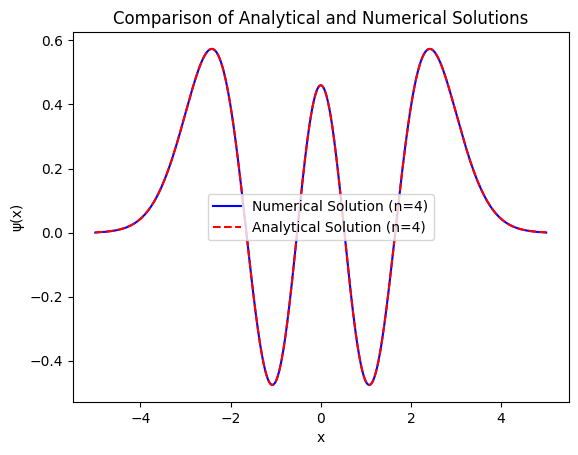

In [ ]:
# Numerical solution using finite difference method
def numerical_schrodinger(N, x_min, x_max):
    """ Solve the Schrödinger equation numerically using finite differences. """
    x_vals = np.linspace(x_min, x_max, N)
    h = x_vals[1] - x_vals[0]  # Step size

    # Discretized second derivative (Laplacian)
    diag = 1 / h**2 + harmonic_potential(x_vals)
    off_diag = np.full(N - 1, -1 / (2 * h**2))

    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = eigh_tridiagonal(diag, off_diag)

    return x_vals, eigenvalues, eigenvectors

# Solve numerically
N = 1000
x_vals, eigvals, eigvecs = numerical_schrodinger(N, -5, 5)

# Extract numerical eigenfunction for n=4
psi_numerical = eigvecs[:, n]

# Normalize
psi_numerical /= np.sqrt(np.trapz(psi_numerical**2, x_vals))

# Plot numerical vs analytical solution
plt.plot(x_vals, psi_numerical, label=f"Numerical Solution (n={n})", linestyle="solid", color="blue")
plt.plot(x_vals, psi_analytical, label=f"Analytical Solution (n={n})", linestyle="--", color="red")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.legend()
plt.title("Comparison of Analytical and Numerical Solutions")
plt.show()

# Working Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.special import hermite
from scipy.special import factorial
import matplotlib.pyplot as plt

In [29]:
def quantum_harmonic_oscillator(n, x):
    """
    Quantum harmonic oscillator state function for n-th energy level.

    Parameters:
    - n: Quantum number
    - x: Position (torch.Tensor)

    Returns:
    - y: The n-th state wave function evaluated at x
    """
    # Given values
    m = 1  # mass
    omega = 1  # angular frequency
    hbar = 1  # reduced Planck's constant
    prefactor = ((m*omega)/(np.pi*hbar))**0.25
    normalization = 1 / np.sqrt(2**n * factorial(n))
    x_np = x.numpy()
    # Calculate the Hermite polynomial H_n
    H_n = hermite(n)(np.sqrt(m*omega/hbar)*x_np)
    # Compute the wave function
    y_np = prefactor * normalization * H_n * np.exp(-m*omega*x_np**2 / (2*hbar))
    # Convert the result back to a torch.Tensor
    y = torch.from_numpy(y_np).type_as(x)
    return y

# Custom Sine activation function
class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class FCN(nn.Module):
    def __init__(self, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        self.activation = SineActivation()  # Use the sine activation function
        self.initial_layer = nn.Linear(1, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.activation(self.initial_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

# Example usage
N_OUTPUT = 1  # Output size
N_HIDDEN = 50  # Number of neurons in the hidden layers
N_LAYERS = 3  # Number of hidden layers

model = FCN(N_OUTPUT, N_HIDDEN, N_LAYERS)

# get the analytical solution over the full domain
n = 10 # nth eigenstate
x = torch.linspace(-12,12,10000).view(-1,1)
y = quantum_harmonic_oscillator(n, x).view(-1,1)

# Generate 20 equally spaced data points within the range [-7, 7]
x_start, x_end = -7, 7
num_points = 40
x_data = torch.linspace(x_start, x_end, num_points).view(-1, 1)
y_data = quantum_harmonic_oscillator(n, x_data).view(-1, 1)


x_physics = torch.linspace(-12,12,50).view(-1,1).requires_grad_(True) # sample locations over the problem domain

torch.manual_seed(123)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)

#plt.close()
for i in range(2000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 - (x_physics ** 2) * yhp + 2 * (n + 0.5) * yhp
    loss2 = 5e-3 * torch.mean(physics ** 2)

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()

    if i%100==0:
      print(f"For {i}th epoch the loss1 is {loss1} and loss2 is {loss2}, and total loss is {loss}")

with torch.inference_mode():
  yh = model(x).detach()

For 0th epoch the loss1 is 0.07159436494112015 and loss2 is 0.3421269953250885, and total loss is 0.41372135281562805
For 100th epoch the loss1 is 0.059520114213228226 and loss2 is 0.001725977286696434, and total loss is 0.06124608963727951
For 200th epoch the loss1 is 0.055453110486269 and loss2 is 0.0013408638769760728, and total loss is 0.056793972849845886
For 300th epoch the loss1 is 0.028804879635572433 and loss2 is 0.006265362724661827, and total loss is 0.03507024049758911
For 400th epoch the loss1 is 0.00730137387290597 and loss2 is 0.0024281712248921394, and total loss is 0.009729545563459396
For 500th epoch the loss1 is 0.003397579537704587 and loss2 is 0.0012171295238658786, and total loss is 0.004614708945155144
For 600th epoch the loss1 is 0.002427139785140753 and loss2 is 0.0038010620046406984, and total loss is 0.006228202022612095
For 700th epoch the loss1 is 0.0013544325483962893 and loss2 is 0.0006390042253769934, and total loss is 0.0019934368319809437
For 800th epo

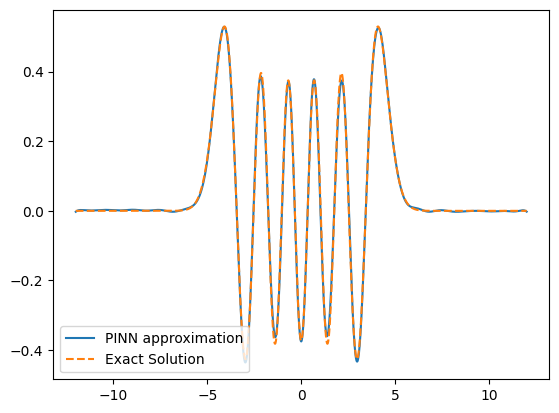

In [30]:
plt.plot(x, yh, label='PINN approximation')
plt.plot(x, y, linestyle='--', label='Exact Solution')
plt.legend()